<a href="https://colab.research.google.com/github/sajan-sarker/java-python-code-translation/blob/main/java-to-python-codet5-small-plbart-base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Details
# This notebook contain the CodeT5 small and PLBART Base model Fine Tuning codes.
# CodeT5 small used to translate the Java codes into Python codes.
# PLBART base model was used to correct the translated python codes.

# BLEU evaluation metrics was used here.
# Directory structures:
  - datasets (avatar tc parallel java-python code pairs datasets as train, valid, test)
  - models
    - codet5 (checkpoint and finetune model)
    - plbart (checkpoint and finetune model)
  - outputs
    - codet5_translations (contain the translated train, valid, test dataset that used to train the plbart model)
    - plbart_tranlations (contain the corrected test dataset that used for evaluation)
    - training_log.txt [codet5 training logs]
  - results
    - codet5 (loss curves and training scores)
    - plbart (loss curves and training scores)


# Notebook Structure
  - Installations
  - Necessary Imports
  - Configurations
  - Common Helper Functions
  - Codet5
  - Plbart
  - Inference

*****
# Installations

In [ ]:
!pip install transformers==4.51.0 -q
!pip install sacrebleu==2.5.1 -q
!pip install -q gdown

!gdown --folder https://drive.google.com/drive/folders/1r4iIHQNDxtsDRaYcXYjTugDXR_D3_KDu?usp=drive_link
!gdown --folder https://drive.google.com/drive/folders/1uy70PCJ8xSwjRlXTUP8nQzW5FiFHX0DV?usp=drive_link
!gdown --folder https://drive.google.com/drive/folders/1RfjyAuXOjo3NEDtgrEjOtejYIf_iMa6K?usp=drive_link

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00
Retrieving folder contents
Processing file 1ibRJPEGiKO0B9AE1wn9_bZvPRhhDR7nX test.java-python.java
Processing file 1BQ8deyS_XdfReCv5JaGhmMWZ2ivF9RDz test.java-python.python
Processing file 1Fdi-fNNTGd997Tg1TF1ABpCQiWhYGwY_ train.java-python.java
Processing file 1ovLRwrh5kQUklHmrxJBmPntuNSq0IhfC train.java-python.python
Processing file 1S7p6P_PRBBoT-0HyX7E_nOME4Q45yDzR valid.java-python.java
Processing file 1_I8e9oc553Oltq--86g00FHhryfnaw8m valid.java-python.python
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ibRJPEGiKO0B9AE1wn9_bZvPRhhDR7nX
To: /content/datasets/test.java-python.java
100% 1.26M/1.26M [00:00<00:00, 162MB/s]
Downloading...
Fr

In [ ]:
# Original Dataset  ---------------------------------------------------------------
# !gdown --folder https://drive.google.com/drive/folders/1r4iIHQNDxtsDRaYcXYjTugDXR_D3_KDu?usp=drive_link

# Translated Dataset  ---------------------------------------------------------------
# !gdown --folder https://drive.google.com/drive/folders/1uy70PCJ8xSwjRlXTUP8nQzW5FiFHX0DV?usp=drive_link

# Models  ---------------------------------------------------------------
# !gdown --folder https://drive.google.com/drive/folders/1RfjyAuXOjo3NEDtgrEjOtejYIf_iMa6K?usp=drive_link

*****
# Necessary Imports

In [ ]:
import json
import logging
import os
import re
import sys
import nltk
import warnings
import shutil
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sacrebleu
import torch
import torch.nn as nn

from IPython.display import FileLink
from sacrebleu import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
from transformers import RobertaTokenizer, T5ForConditionalGeneration, PLBartForConditionalGeneration, PLBartTokenizer

nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# setup random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True

# create directories for models and results
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('outputs/codet5_translations', exist_ok=True)
cwd = os.getcwd()

# Setup logging with detailed format
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(cwd, 'results', 'training.log')),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Total GPUs: {torch.cuda.device_count()}")
print(f"GPU Names: {[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]}")

Total GPUs: 1
GPU Names: ['Tesla T4']


*****
# Configurations

In [ ]:
MAX_SOURCE_LEN_JAVA = 350
MAX_SOURCE_LEN_PYTHON = 256
MAX_TARGET_LEN_PYTHON = 256
BATCH_SIZE = 16

# CODET5
CODET5_LEARNING_RATE = 3e-4
CODET5_WEIGHT_DECAY = 0.05

CODET5_EPOCHS = 10
CODET5_TOTAL_EPOCHS = 10

# PLBART
PLBART_LEARNING_RATE = 3e-5
PLBART_WEIGHT_DECAY = 0.01

PLBART_EPOCHS = 10

# COMMON
GRADIENT_ACCUMULATION_STEPS = 2
EARLY_STOPPING_PATIENCE = 6

*****
# Common Helper Functions

In [ ]:
def generate_translations(model, tokenizer, data_loader, output_file):
    model.eval()
    translations = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating Translations", total=len(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=MAX_TARGET_LEN_PYTHON,
                num_beams=10,
                early_stopping=True
            )

            decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            translations.extend(decoded)

    # Save results
    with open(output_file, 'w', encoding='utf-8') as f:
        for translated_code in translations:
            f.write(translated_code + '\n')
    print(f"\n✅ Translations saved to: {output_file}")

    return translations

def evaluate_model(original_file, predicted_file, stage="CodeT5"):
    def normalize_code(code):
        return re.sub(r'\s+', ' ', code.strip())

    def load_file(path):
        data = []
        with open(path, encoding='utf-8') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                data.append(line.strip().replace("\t", "    "))
        return data

    try:
        # load data from files
        references = load_file(original_file)
        translations = load_file(predicted_file)

        # checking for both file length
        if len(references) != len(translations):
            logger.error(f"Mismatch in number of samples: {len(references)} references vs {len(translations)} predictions")
            raise ValueError("Number of samples in original and predicted files must match")

        # calculating em(exact match) scores
        em_scores = [1 if normalize_code(pred) == normalize_code(ref) else 0 for pred, ref in zip(translations, references)]
        em_score = sum(em_scores) / len(em_scores) if em_scores else 0

        # calculating bleu scores
        bleu_scorer = sacrebleu.BLEU()
        bleu = bleu_scorer.corpus_score(translations, [references]).score / 100  # normalize between 0 to 1

        metrics = {
            'em_score': em_score,
            'bleu': bleu
        }

        print(f"{stage} Evaluation Metrics:")
        print(json.dumps(metrics, indent=2))

        with open(f'{cwd}/results/{stage.lower()}_evaluation_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=2)

        return metrics

    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        raise

def learning_curve(train_loss, val_loss, train_acc, val_acc, bleu, title, path='results/codeT5'):
    os.makedirs((os.getcwd()+'results'), exist_ok=True)

    # loss curve
    plt.figure(figsize=(7, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title(f"{title} Loss Curve")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}_loss_curve.png')
    plt.show()
    plt.close()

    print()

    # accuradcy curve
    plt.figure(figsize=(7, 6))
    plt.plot(train_acc, label='Training Accuracy', color='red')
    plt.plot(val_acc, label='Validation Accuracy', color='yellow')
    plt.plot(bleu, label='Validation BLEU', color='green')
    plt.title(f"{title} Accuracy Curve")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}_accuracy_curve.png')
    plt.show()
    plt.close()

*****
*****
# CodeT5
*****
*****

*****
# CodeT5 Dataset & Functions

In [ ]:
# setup dataset for java to python translation task
class CodeTranslationDataset(Dataset):
    def __init__(self, java_file, python_file, tokenizer, max_source_len, max_target_len, prefix="Translate Java Code into Python Code: "):
        self.java_codes = self.load_code(java_file)
        self.python_codes = self.load_code(python_file)
        self.tokenizer = tokenizer
        self.max_source_len = max_source_len
        self.max_target_len = max_target_len
        self.prefix = prefix

        if len(self.java_codes) != len(self.python_codes):
            print("Dataset sizes do not match")
            raise ValueError(f"Java ({len(self.java_codes)}) and Python ({len(self.python_codes)}) dataset sizes do not match")

    def load_code(self, file_path):
        try:
            data = []
            with open(file_path, encoding='utf-8') as f:
                while True:
                    line = f.readline()
                    if not line:
                        break
                    data.append(line.strip().replace("\t", "    "))
            return data

        except FileNotFoundError:
            print(f"File not found! {file_path}")
            raise

        except Exception as e:
            print(f"Error reading file: {file_path}: {e}")
            raise

    def __len__(self):
        return len(self.java_codes)

    def __getitem__(self, idx):
        java_code = self.prefix + self.java_codes[idx]
        python_code = self.python_codes[idx]

        try:
            java_encoding = self.tokenizer(
                java_code,
                max_length=self.max_source_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            python_encoding = self.tokenizer(
                python_code,
                max_length=self.max_target_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            return {
                'input_ids': java_encoding['input_ids'].squeeze(),
                'attention_mask': java_encoding['attention_mask'].squeeze(),
                'labels': python_encoding['input_ids'].squeeze()
            }
        except Exception as e:
            print(f"Error tokenizing data at index {idx}: {str(e)}")
            raise

In [ ]:
# dataloader function
def load_data(java_file, python_file, tokenizer, max_source_len, max_target_len, batch_size, shuffle=False):
    dataset = CodeTranslationDataset(
        java_file, python_file, tokenizer, max_source_len, max_target_len
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    return dataloader

In [ ]:
def train_codet5(model, tokenizer, train_loader, val_loader, optimizer, session_epochs, total_epochs, output_dir='models/codet5', checkpoint_frequency=1, resume_from_checkpoint=None, label_smoothing_factor=0.1):
    """Train CodeT5 model with early stopping, gradient accumulation, and FileLink for checkpoints."""
    os.makedirs(output_dir, exist_ok=True)

    logging.basicConfig(
        filename=os.path.join(output_dir, 'training_log.txt'),
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        force=True
    )
    logger = logging.getLogger()

    # label smoothing setup
    use_custom_loss = False
    if hasattr(model.config, 'label_smoothing_factor'):
        model.config.label_smoothing_factor = label_smoothing_factor
    else:
        use_custom_loss = True
        ce_loss = nn.CrossEntropyLoss(
            label_smoothing=label_smoothing_factor,
            ignore_index=tokenizer.pad_token_id
        )

    # Initialize metrics
    train_losses, val_losses, train_accuracies, val_accuracies, val_bleu_scores = [], [], [], [], []
    start_epoch = 0
    best_val_loss = float('inf')
    patience_counter = 0

    # Load checkpoint
    if resume_from_checkpoint:
        checkpoint_path = os.path.join(resume_from_checkpoint, 'checkpoint.pt')
        if os.path.exists(checkpoint_path):
            try:
                checkpoint = torch.load(checkpoint_path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                scheduler_state = checkpoint.get('scheduler_state_dict', None)
                start_epoch = checkpoint['epoch'] + 1
                train_losses = checkpoint['train_losses']
                val_losses = checkpoint['val_losses']
                train_accuracies = checkpoint['train_accuracies']
                val_accuracies = checkpoint['val_accuracies']
                val_bleu_scores = checkpoint.get('val_bleu_scores', [])
                best_val_loss = min(val_losses) if val_losses else float('inf')
                print(f"Resumed from checkpoint at epoch {start_epoch}")
            except Exception as e:
                print(f"Checkpoint Load Error: {e}")
        else:
            print(f"Checkpoint {checkpoint_path} not found")

    # optimizer and scheduler
    total_steps = len(train_loader) * (total_epochs - start_epoch) // GRADIENT_ACCUMULATION_STEPS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    if resume_from_checkpoint and scheduler_state:
        try:
            scheduler.load_state_dict(scheduler_state)
            print("Scheduler state loaded")
        except Exception as e:
            print(f"Scheduler Load Error: {e}")

    scaler = GradScaler()
    for epoch in range(start_epoch, start_epoch + session_epochs):
        model.train()
        total_train_loss = 0
        correct, total = 0, 0
        optimizer.zero_grad()

        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{total_epochs}', leave=True)
        for i, batch in enumerate(train_bar):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                with autocast():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss if not use_custom_loss else ce_loss(
                        outputs.logits.view(-1, outputs.logits.size(-1)),
                        labels.view(-1)
                    )
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                scaler.scale(loss).backward()
                if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                total_train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                preds = torch.argmax(outputs.logits, dim=-1)
                mask = labels != tokenizer.pad_token_id
                correct += ((preds == labels) * mask).sum().item()
                total += mask.sum().item()

            except RuntimeError as e:
                print(f"Training Error: {e}")
                continue

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct / total if total > 0 else 0
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        total_val_loss = 0
        correct, total = 0, 0
        bleu_scores = []

        val_bar = tqdm(val_loader, desc='Validating', leave=True)
        with torch.no_grad():
            for batch in val_bar:
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    with autocast():
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                        loss = outputs.loss if not use_custom_loss else ce_loss(
                            outputs.logits.view(-1, outputs.logits.size(-1)),
                            labels.view(-1)
                        )

                    total_val_loss += loss.item()
                    preds = torch.argmax(outputs.logits, dim=-1)
                    mask = labels != tokenizer.pad_token_id
                    correct += ((preds == labels) * mask).sum().item()
                    total += mask.sum().item()

                    for pred_seq, label_seq in zip(preds, labels):
                        pred_text = tokenizer.decode(pred_seq[mask[0]], skip_special_tokens=True)
                        label_text = tokenizer.decode(label_seq[mask[0]], skip_special_tokens=True)
                        if pred_text.strip() and label_text.strip():
                            bleu = sacrebleu.sentence_bleu(
                                pred_text,
                                [label_text],
                                smooth_method='exp'
                            ).score / 100
                            bleu_scores.append(bleu)

                except RuntimeError as e:
                    print(f"Validation Error: {e}")
                    continue

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total if total > 0 else 0
        avg_bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_bleu_scores.append(avg_bleu_score)

        # print epoch results to console
        log_message = (
            f"Epoch {epoch+1}/{total_epochs} | Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
            f"Val Acc: {val_accuracy:.4f} | Val BLEU: {avg_bleu_score:.4f}"
        )
        print(log_message)

        # Save checkpoint
        if (epoch + 1 - start_epoch) % checkpoint_frequency == 0 or epoch + 1 == start_epoch + session_epochs:
            checkpoint_dir = os.path.join(output_dir, f'checkpoint_epoch_{epoch+1}')
            os.makedirs(checkpoint_dir, exist_ok=True)
            try:
                model.save_pretrained(checkpoint_dir)
                tokenizer.save_pretrained(checkpoint_dir)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'val_bleu_scores': val_bleu_scores
                }, os.path.join(checkpoint_dir, 'checkpoint.pt'))
                print(f"Checkpoint saved to {checkpoint_dir}")

                # zip the checkpoint after every epoch
                zip_path = os.path.join(output_dir, f'checkpoint_epoch_{epoch+1}.zip')
                with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
                    for root, _, files in os.walk(checkpoint_dir):
                        for file in files:
                            file_path = os.path.join(root, file)
                            zipf.write(
                                file_path,
                                os.path.relpath(file_path, output_dir)
                            )
                print(f"Created zip file: {zip_path}")

                # show download link for each epoch checkpoint
                if os.path.exists(zip_path):
                    try:
                        if 'IPython' in sys.modules and hasattr(sys.modules['IPython'], 'get_ipython'):
                            link = FileLink(zip_path)
                            display(link)
                            print(f"Download checkpoint for epoch {epoch+1}: {link}")
                        else:
                            abs_zip_path = os.path.abspath(zip_path)
                            print(f"Checkpoint zip at: {abs_zip_path}")
                    except Exception as e:
                        print(f"Checkpoint at: {os.path.abspath(zip_path)}")
                else:
                    print(f"Zip file {zip_path} was not created")

            except Exception as e:
                print(f"Error saving checkpoint: {e}")

        # early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # save metrics
    try:
        metrics_df = pd.DataFrame({
            'epoch': list(range(1, len(train_losses) + 1)),
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_accuracy': train_accuracies,
            'val_accuracy': val_accuracies,
            'val_bleu_score': val_bleu_scores
        })
        csv_path = os.path.join(output_dir, 'codet5_training_scores.csv')
        metrics_df.to_csv(csv_path, index=False)
        print(f"Training metrics saved to {csv_path}")

        # generate csv download link
        if os.path.exists(csv_path):
            try:
                if 'IPython' in sys.modules and hasattr(sys.modules['IPython'], 'get_ipython'):
                    csv_link = FileLink(csv_path)
                    display(csv_link)
                    print(f"Download training metrics CSV: {csv_link}")
                else:
                    abs_csv_path = os.path.abspath(csv_path)
                    print(f"FileLink not supported in this environment. Access the metrics CSV at: {abs_csv_path}")
            except Exception as e:
                abs_csv_path = os.path.abspath(csv_path)
                print(f"Failed to create FileLink. Access the metrics CSV at: {abs_csv_path}")
        else:
            print(f"Error: Metrics CSV {csv_path} was not created")

        # generate log download link
        log_path = os.path.join(output_dir, 'training_log.txt')
        if os.path.exists(log_path):
            try:
                if 'IPython' in sys.modules and hasattr(sys.modules['IPython'], 'get_ipython'):
                    log_link = FileLink(log_path)
                    display(log_link)
                    print(f"Download training log: {log_link}")
                else:
                    abs_log_path = os.path.abspath(log_path)
                    print(f"FileLink not supported in this environment. Access the training log at: {abs_log_path}")
            except Exception as e:
                logger.error(f"Error creating FileLink for {log_path}: {e}")
                abs_log_path = os.path.abspath(log_path)
                print(f"Failed to create FileLink. Access the training log at: {abs_log_path}")
        else:
            print(f"Error: Training log {log_path} was not created")

    except Exception as e:
        print(f"Error saving metrics: {e}")

    return train_losses, val_losses, train_accuracies, val_accuracies, val_bleu_scores

*****
# CodeT5 Training


#### Modell Loading

In [ ]:
# load codet5 tokenizers and model
print("Loading CodeT5 model and tokenizer: \n")
codet5_tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')
codet5_model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-small').to(device)

# loading dataset and create dataloader
print("\nLoading datasets")
train_loader = load_data(
    java_file=cwd+'/datasets/train.java-python.java',
    python_file=cwd+'/datasets/train.java-python.python',
    tokenizer=codet5_tokenizer,
    max_source_len=MAX_SOURCE_LEN_JAVA,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = load_data(
    java_file=cwd+'/datasets/valid.java-python.java',
    python_file=cwd+'/datasets/valid.java-python.python',
    tokenizer=codet5_tokenizer,
    max_source_len=MAX_SOURCE_LEN_JAVA,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)
test_loader = load_data(
    java_file=cwd+'/datasets/test.java-python.java',
    python_file=cwd+'/datasets/test.java-python.python',
    tokenizer=codet5_tokenizer,
    max_source_len=MAX_SOURCE_LEN_JAVA,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)
print("\n-----------------------")
print("    Dataset Details:    ")
print("-----------------------")
print("# of Training samples:", len(train_loader.dataset))
print("# of Validation samples:", len(val_loader.dataset))
print("# of Test samples:", len(test_loader.dataset))
print("-----------------------\n")

Loading CodeT5 model and tokenizer: 



tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]


Loading datasets

-----------------------
    Dataset Details:    
-----------------------
# of Training samples: 55179
# of Validation samples: 443
# of Test samples: 1746
-----------------------



#### Datasets

In [ ]:
def verify_dataset(java_file, python_file):
    with open(java_file, 'r', encoding='utf-8') as jf, open(python_file, 'r', encoding='utf-8') as pf:
        java_lines = jf.readlines()
        python_lines = pf.readlines()
        print(f"Java file lines: {len(java_lines)}")
        print(f"Python file lines: {len(python_lines)}")
        print("\nSample Java:\n", java_lines[0].strip() if java_lines else "Empty")
        print("\nSample Python:\n", python_lines[0].strip() if python_lines else "Empty")

verify_dataset('datasets/train.java-python.java', 'datasets/train.java-python.python')

Java file lines: 55179
Python file lines: 55179

Sample Java:
 import java . util . * ; class TreeNode { public int val ; public TreeNode left ; public TreeNode right ; public TreeNode ( int rootData ) { this . val = rootData ; this . left = null ; this . right = null ; } } public class Solution { public TreeNode convertBST ( TreeNode root ) { int sum = 0 ; TreeNode node = root ; Stack < TreeNode > stack = new Stack < TreeNode > ( ) ; while ( ! stack . isEmpty ( ) || node != null ) { while ( node != null ) { stack . add ( node ) ; node = node . right ; } node = stack . pop ( ) ; sum += node . val ; node . val = sum ; node = node . left ; } return root ; } public List < Integer > printTree_vLR ( TreeNode node , List < Integer > arr ) { if ( node != null ) { arr . add ( node . val ) ; arr = printTree_vLR ( node . left , arr ) ; arr = printTree_vLR ( node . right , arr ) ; } return arr ; } public static void main ( String [ ] args ) { Solution sObj = new Solution ( ) ; TreeNode root = new

In [ ]:
sample_batch_python = next(iter(train_loader))  # get a single batch from the train_loader

print("Sample batch from train_loader:")
for key, value in sample_batch_python.items():
    print(f"{key}:")
    print(value)
    print()

Sample batch from train_loader:
input_ids:
tensor([[    1, 12818,  5110,  ...,    79,   263,     2],
        [    1, 12818,  5110,  ...,   760,   509,     2],
        [    1, 12818,  5110,  ...,     0,     0,     0],
        ...,
        [    1, 12818,  5110,  ...,   327,  3407,     2],
        [    1, 12818,  5110,  ...,     0,     0,     0],
        [    1, 12818,  5110,  ...,     0,     0,     0]])

attention_mask:
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

labels:
tensor([[    1,    69,   269,  ...,     0,     0,     0],
        [    1,   455,   273,  ...,     0,     0,     0],
        [    1,  1188,   261,  ...,     0,     0,     0],
        ...,
        [    1,  5666,  2589,  ...,   273,   374,     2],
        [    1,    82,   273,  ...,     0,     0,     0],
        [    1,   536, 12439,  ..., 12887,    67

#### Training

In [ ]:
# setup otimizer
codet5_optimizer = torch.optim.AdamW(
    codet5_model.parameters(),
    lr=CODET5_LEARNING_RATE,
    weight_decay=CODET5_WEIGHT_DECAY,
    eps=1e-8
)

In [ ]:
# finetuning model
# initial epochs 1 to 10
codet5_train_losses, codet5_val_losses, codet5_train_accs, codet5_val_accs, codet5_val_bleu_scores = train_codet5(
    model=codet5_model,
    tokenizer=codet5_tokenizer,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=codet5_optimizer,
    session_epochs=CODET5_EPOCHS,
    total_epochs=CODET5_TOTAL_EPOCHS,
    output_dir='models/codet5',
    checkpoint_frequency=1,
    label_smoothing_factor=0.1
)

Validating: 100%|██████████| 56/56 [00:27<00:00,  2.06it/s]


Epoch 1/10 | Train Loss: 2.4952 | Val Loss: 1.8258 | Train Acc: 0.7473 | Val Acc: 0.8900 | Val BLEU: 0.7884


/content/models/codet5/checkpoint_epoch_1.zip

Download checkpoint for epoch 1: /content/models/codet5/checkpoint_epoch_1.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.07it/s]


Epoch 2/10 | Train Loss: 2.0683 | Val Loss: 1.7546 | Train Acc: 0.8196 | Val Acc: 0.9061 | Val BLEU: 0.8155


/content/models/codet5/checkpoint_epoch_2.zip

Download checkpoint for epoch 2: /content/models/codet5/checkpoint_epoch_2.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.04it/s]


Epoch 3/10 | Train Loss: 1.9735 | Val Loss: 1.7402 | Train Acc: 0.8401 | Val Acc: 0.9088 | Val BLEU: 0.8203


/content/models/codet5/checkpoint_epoch_3.zip

Download checkpoint for epoch 3: /content/models/codet5/checkpoint_epoch_3.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Epoch 4/10 | Train Loss: 1.9277 | Val Loss: 1.7324 | Train Acc: 0.8508 | Val Acc: 0.9109 | Val BLEU: 0.8242


/content/models/codet5/checkpoint_epoch_4.zip

Download checkpoint for epoch 4: /content/models/codet5/checkpoint_epoch_4.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Epoch 5/10 | Train Loss: 1.9096 | Val Loss: 1.7322 | Train Acc: 0.8553 | Val Acc: 0.9117 | Val BLEU: 0.8246


/content/models/codet5/checkpoint_epoch_5.zip

Download checkpoint for epoch 5: /content/models/codet5/checkpoint_epoch_5.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.02it/s]


Epoch 6/10 | Train Loss: 1.9044 | Val Loss: 1.7308 | Train Acc: 0.8566 | Val Acc: 0.9120 | Val BLEU: 0.8257


/content/models/codet5/checkpoint_epoch_6.zip

Download checkpoint for epoch 6: /content/models/codet5/checkpoint_epoch_6.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Epoch 7/10 | Train Loss: 1.9007 | Val Loss: 1.7305 | Train Acc: 0.8577 | Val Acc: 0.9120 | Val BLEU: 0.8259


/content/models/codet5/checkpoint_epoch_7.zip

Download checkpoint for epoch 7: /content/models/codet5/checkpoint_epoch_7.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.03it/s]


Epoch 8/10 | Train Loss: 1.8992 | Val Loss: 1.7290 | Train Acc: 0.8581 | Val Acc: 0.9127 | Val BLEU: 0.8266


/content/models/codet5/checkpoint_epoch_8.zip

Download checkpoint for epoch 8: /content/models/codet5/checkpoint_epoch_8.zip


Validating: 100%|██████████| 56/56 [00:27<00:00,  2.00it/s]


Epoch 9/10 | Train Loss: 1.8943 | Val Loss: 1.7283 | Train Acc: 0.8594 | Val Acc: 0.9128 | Val BLEU: 0.8269


/content/models/codet5/checkpoint_epoch_9.zip

Download checkpoint for epoch 9: /content/models/codet5/checkpoint_epoch_9.zip


Validating: 100%|██████████| 56/56 [00:29<00:00,  1.93it/s]


Epoch 10/10 | Train Loss: 1.8913 | Val Loss: 1.7283 | Train Acc: 0.8602 | Val Acc: 0.9130 | Val BLEU: 0.8273


/content/models/codet5/checkpoint_epoch_10.zip

Download checkpoint for epoch 10: /content/models/codet5/checkpoint_epoch_10.zip


/content/models/codet5/codet5_training_scores.csv

Download training metrics CSV: /content/models/codet5/codet5_training_scores.csv


/content/models/codet5/training_log.txt

Download training log: /content/models/codet5/training_log.txt


In [ ]:
# saving the checkpoint on google drive
zip_file_name = 'checkpoint_epoch_10.zip'
drive_target_folder = '/content/drive/MyDrive/models/codet5'
os.makedirs(drive_target_folder, exist_ok=True)

source_path = f'/content/models/codet5/{zip_file_name}'
target_path = os.path.join(drive_target_folder, zip_file_name)

print(f"Source Path: {source_path}")
print(f"Target Path: {target_path}")

try:
    file_size = os.path.getsize(source_path)
    chunk_size = 1024 * 1024  # 1MB

    with open(source_path, 'rb') as src_file, open(target_path, 'wb') as dst_file:
        with tqdm(total=file_size, unit='B', unit_scale=True, desc="Copying") as pbar:
            while True:
                chunk = src_file.read(chunk_size)
                if not chunk:
                    break
                dst_file.write(chunk)
                pbar.update(len(chunk))

    print(f"\n✅ File '{zip_file_name}' successfully copied to '{drive_target_folder}'")
except FileNotFoundError:
    print(f"\n❌ File '{zip_file_name}' not found in Colab workspace.")
except Exception as e:
    print(f"\n⚠️ Error: {e}")

Source Path: /content/models/codet5/checkpoint_epoch_10.zip
Target Path: /content/drive/MyDrive/models/codet5/checkpoint_epoch_10.zip


Copying: 100%|██████████| 893M/893M [00:08<00:00, 104MB/s] 


✅ File 'checkpoint_epoch_10.zip' successfully copied to '/content/drive/MyDrive/models/codet5'


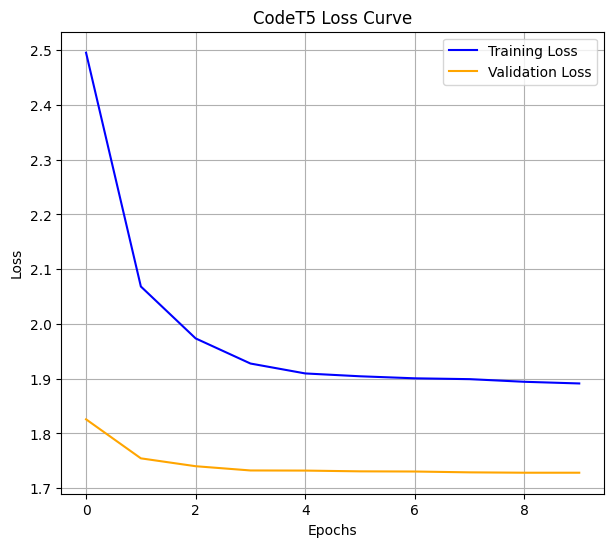

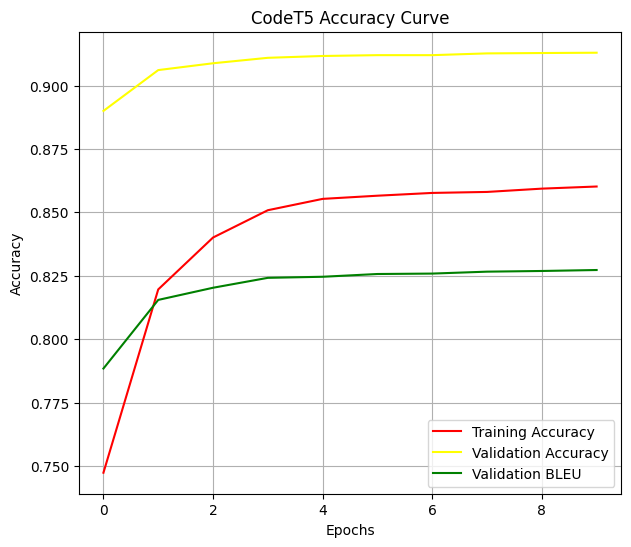

In [ ]:
learning_curve(codet5_train_losses, codet5_val_losses, codet5_train_accs, codet5_val_accs, codet5_val_bleu_scores, "CodeT5")

*****
# Dataset Translation

#### Checkpoint Loading

In [ ]:
# load codet5 andtokenizers model from checkppoint
print("Loading CodeT5 model and tokenizer from Checkpoint")
codet5_tokenizer = RobertaTokenizer.from_pretrained('models/codet5/checkpoint_epoch_10')
codet5_model = T5ForConditionalGeneration.from_pretrained('models/codet5/checkpoint_epoch_10').to(device)

# loading dataset and create dataloader
print("\nLoading datasets")
train_loader = load_data(
    java_file=cwd+'/datasets/train.java-python.java',
    python_file=cwd+'/datasets/train.java-python.python',
    tokenizer=codet5_tokenizer,
    max_source_len=MAX_SOURCE_LEN_JAVA,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)
val_loader = load_data(
    java_file=cwd+'/datasets/valid.java-python.java',
    python_file=cwd+'/datasets/valid.java-python.python',
    tokenizer=codet5_tokenizer,
    max_source_len=MAX_SOURCE_LEN_JAVA,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)
test_loader = load_data(
    java_file=cwd+'/datasets/test.java-python.java',
    python_file=cwd+'/datasets/test.java-python.python',
    tokenizer=codet5_tokenizer,
    max_source_len=MAX_SOURCE_LEN_JAVA,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)
print("\n-----------------------")
print("    Dataset Details:    ")
print("-----------------------")
print("# of Training samples:", len(train_loader.dataset))
print("# of Validation samples:", len(val_loader.dataset))
print("# of Test samples:", len(test_loader.dataset))
print("-----------------------\n")

Loading CodeT5 model and tokenizer from Checkpoint

Loading datasets

-----------------------
    Dataset Details:    
-----------------------
# of Training samples: 55179
# of Validation samples: 443
# of Test samples: 1746
-----------------------



In [ ]:
codet5_model

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

#### Model Saving

In [ ]:
codet5_model.save_pretrained('models/codet5/codet5_java_translation')
codet5_tokenizer.save_pretrained('models/codet5/codet5_java_translation')

('models/codet5/codet5_java_translation/tokenizer_config.json',
 'models/codet5/codet5_java_translation/special_tokens_map.json',
 'models/codet5/codet5_java_translation/vocab.json',
 'models/codet5/codet5_java_translation/merges.txt',
 'models/codet5/codet5_java_translation/added_tokens.json')

In [ ]:
# zipping the finetuned model
model_dir = 'models/codet5/codet5_java_translation'
zip_path = 'models/codet5/codet5_java_translation.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_dir)
FileLink(zip_path)

/content/models/codet5/codet5_java_translation.zip

In [ ]:
def get_dir_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size

size_bytes = get_dir_size('models/codet5/codet5_java_translation')
size_mb = size_bytes / (1024 * 1024)

print(f"Directory size: {size_mb:.2f} MB")

Directory size: 231.69 MB


#### Translation Generation

In [ ]:
print("CodeT5 Code Translation Data:")
print("Training Data: ")
train_translated = generate_translations(codet5_model, codet5_tokenizer, train_loader, output_file='outputs/codet5_translations/train.translated-python.python')

CodeT5 Code Translation Data:
Training Data: 


Generating Translations: 100%|██████████| 432/432 [2:31:01<00:00, 20.98s/it]


✅ Translations saved to: outputs/codet5_translations/train.translated-python.python


In [ ]:
print("Validation Data: ")
val_translated = generate_translations(codet5_model, codet5_tokenizer, val_loader, output_file='outputs/codet5_translations/valid.translated-python.python')

Validation Data: 


Generating Translations: 100%|██████████| 4/4 [01:14<00:00, 18.55s/it]


✅ Translations saved to: outputs/codet5_translations/valid.translated-python.python


In [ ]:
print("Test Data: ")           # translated with beam size of 2 for next step correction
test_translated = generate_translations(codet5_model, codet5_tokenizer, test_loader, output_file='outputs/codet5_translations/test.translated-python.python')

Test Data: 


Generating Translations: 100%|██████████| 14/14 [04:54<00:00, 21.04s/it]


✅ Translations saved to: outputs/codet5_translations/test.translated-python.python


In [ ]:
print("Test Data for Evaluate the Model: ")           # translated with beam size of 10 and batch size of 8
test_translated_eval = generate_translations(codet5_model, codet5_tokenizer, test_loader, output_file='outputs/codet5_translations/test.translated-python-eval.python')

Test Data for Evaluate the Model: 


Generating Translations: 100%|██████████| 219/219 [22:52<00:00,  6.27s/it]


✅ Translations saved to: outputs/codet5_translations/test.translated-python-eval.python


*****
# Model Evaluation

In [ ]:
evaluate_model((cwd+'/datasets/test.java-python.python'), (cwd+'/outputs/codet5_translations/test.translated-python-eval.python'))

{'em_score': 0.028064146620847653, 'bleu': 0.546763524375258}

*****
*****
# PLBART
*****
*****

*****
# PLBART Dataset & Functions

In [ ]:
class CodeCorrectionDataset(Dataset):
    def __init__(self, translated_file, target_file, tokenizer, max_source_len, max_target_len, prefix="Correct this Python code: "):
        self.translated_codes = self.load_code(translated_file)
        self.target_codes = self.load_code(target_file)
        self.tokenizer = tokenizer
        self.max_source_len = max_source_len
        self.max_target_len = max_target_len
        self.prefix = prefix

        if len(self.translated_codes) != len(self.target_codes):
            print("Dataset sizes do not match")
            raise ValueError(f"Translated ({len(self.translated_codes)}) and Target ({len(self.target_codes)}) dataset sizes do not match")

    def load_code(self, file_path):
        try:
            data = []
            with open(file_path, encoding='utf-8') as f:
                while True:
                    line = f.readline()
                    if not line:
                        break
                    data.append(line.strip().replace("\t", "    "))
            return data
        except FileNotFoundError:
            print(f"File not found! {file_path}")
            raise
        except Exception as e:
            print(f"Error reading file: {file_path}: {e}")
            raise

    def __len__(self):
        return len(self.translated_codes)

    def __getitem__(self, idx):
        try:
            input_code = self.prefix + self.translated_codes[idx]
            target_code = self.target_codes[idx]

            input_encoding = self.tokenizer(
                input_code,
                max_length=self.max_source_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            target_encoding = self.tokenizer(
                target_code,
                max_length=self.max_target_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            return {
                'input_ids': input_encoding['input_ids'].squeeze(),
                'attention_mask': input_encoding['attention_mask'].squeeze(),
                'labels': target_encoding['input_ids'].squeeze()
            }
        except Exception as e:
            print(f"Error tokenizing data at index {idx}: {str(e)}")
            raise

In [ ]:
# dataloader function
def load_correction_data(translated_file, target_file, tokenizer, max_source_len, max_target_len, batch_size, shuffle=False):
    dataset = CodeCorrectionDataset(
        translated_file, target_file, tokenizer, max_source_len, max_target_len
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    return dataloader

*****
# PLBART Training

#### Modell Loading

In [ ]:
# load plbart tokenizers and model
print("Loading PLBart model and tokenizer: \n")
plbart_tokenizer = PLBartTokenizer.from_pretrained('uclanlp/plbart-base')
plbart_model = PLBartForConditionalGeneration.from_pretrained('uclanlp/plbart-base').to(device)

# loading dataset and create dataloader
print("\nLoading datasets")
train_loader = load_correction_data(
    translated_file=cwd+'/outputs/codet5_translations/train.translated-python.python',
    target_file=cwd+'/datasets/train.java-python.python',
    tokenizer=plbart_tokenizer,
    max_source_len=MAX_SOURCE_LEN_PYTHON,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = load_correction_data(
    translated_file=cwd+'/outputs/codet5_translations/valid.translated-python.python',
    target_file=cwd+'/datasets/valid.java-python.python',
    tokenizer=plbart_tokenizer,
    max_source_len=MAX_SOURCE_LEN_PYTHON,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)
test_loader = load_correction_data(
    translated_file=cwd+'/outputs/codet5_translations/test.translated-python.python',
    target_file=cwd+'/datasets/test.java-python.python',
    tokenizer=plbart_tokenizer,
    max_source_len=MAX_SOURCE_LEN_PYTHON,
    max_target_len=MAX_TARGET_LEN_PYTHON,
    batch_size=BATCH_SIZE
)

print("\n-----------------------")
print("    Dataset Details:    ")
print("-----------------------")
print("# of Training samples:", len(train_loader.dataset))
print("# of Validation samples:", len(val_loader.dataset))
print("# of Test samples:", len(test_loader.dataset))
print("-----------------------\n")

Loading PLBart model and tokenizer: 



sentencepiece.bpe.model:   0%|          | 0.00/986k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/783 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/557M [00:00<?, ?B/s]


Loading datasets

-----------------------
    Dataset Details:    
-----------------------
# of Training samples: 55179
# of Validation samples: 443
# of Test samples: 1746
-----------------------



#### Datasets

In [ ]:
def verify_dataset(translated, python_file):
    with open(translated, 'r', encoding='utf-8') as jf, open(python_file, 'r', encoding='utf-8') as pf:
        translated_lines = jf.readlines()
        python_lines = pf.readlines()
        print(f"Translated Python file lines: {len(translated_lines)}")
        print(f"Original Python file lines: {len(python_lines)}")
        print("\nSample Translated Python:\n", translated_lines[0].strip() if translated_lines else "Empty")
        print("\nSample Original Python:\n", python_lines[0].strip() if python_lines else "Empty")

verify_dataset('outputs/codet5_translations/train.translated-python.python', 'datasets/train.java-python.python')

Translated Python file lines: 55179
Original Python file lines: 55179

Sample Translated Python:
 class TreeNode : NEW_LINE INDENT def __init__ ( self , rootData ) : NEW_LINE INDENT self . val = rootData NEW_LINE self . left = None NEW_LINE self . right = None NEW_LINE DEDENT DEDENT class Solution ( object ) : NEW_LINE INDENT def convertBST ( self , root ) : NEW_LINE INDENT sum = 0 NEW_LINE node = root NEW_LINE stack = [ ] NEW_LINE while ( len ( stack ) != 0 or node != None ) : NEW_LINE INDENT while ( node != None ) : NEW_LINE INDENT stack . append ( node ) NEW_LINE node = node . right NEW_LINE DEDENT node = stack . pop ( ) NEW_LINE sum += node . val NEW_LINE node . val = sum NEW_LINE node = node . left NEW_LINE DEDENT return root NEW_LINE DEDENT def printTree_vLR ( self , node , arr ) : NEW_LINE INDENT if ( node != None ) : NEW_LINE INDENT arr . append ( node . val ) NEW_LINE arr = printTree_vLR ( node . left , arr ) NEW_LINE arr = printTree_vLR ( node . right ,

Sample Original Pytho

In [ ]:
sample_batch_python = next(iter(train_loader))  # get a single batch from the train_loader

print("Sample batch from train_loader:")
for key, value in sample_batch_python.items():
    print(f"{key}:")
    print(value)
    print()

Sample batch from train_loader:
input_ids:
tensor([[16128,   143,  1123,  ...,     1,     1,     1],
        [16128,   143,  1123,  ...,     1,     1,     1],
        [16128,   143,  1123,  ...,     1,     1,     1],
        ...,
        [16128,   143,  1123,  ...,     1,     1,     1],
        [16128,   143,  1123,  ...,     1,     1,     1],
        [16128,   143,  1123,  ...,     1,     1,     1]])

attention_mask:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

labels:
tensor([[   14,    16,    56,  ...,     1,     1,     1],
        [  200,    24,   142,  ...,     1,     1,     1],
        [  597,     5,   448,  ...,     1,     1,     1],
        ...,
        [  171,    24,   219,  ...,     1,     1,     1],
        [  134, 26433,     5,  ...,    24,   410,     2],
        [  134,   431,     5,  ...,     1,     1

#### Inital Training

In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=plbart_tokenizer,
    model=plbart_model,
    pad_to_multiple_of=8
)

In [ ]:
# initial training arguments for epoch 1 to 10
initial_training_args = TrainingArguments(
    output_dir='models/plbart',
    num_train_epochs=PLBART_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=PLBART_LEARNING_RATE,
    weight_decay=PLBART_WEIGHT_DECAY,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir='results/plbart',
    logging_steps=10,
    logging_strategy="epoch",
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),
    report_to="none",
    save_safetensors=True
)

In [ ]:
# Initializing trainer for the first phase of training
trainer = Trainer(
    model=plbart_model,
    args=initial_training_args,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    data_collator=data_collator
)

In [ ]:
print("PLBart fine-tuning (Epochs 1-10)")
trainer.train()

print("Initial training completed. Checkpoints saved in 'models/plbart'")

PLBart fine-tuning (Epochs 1-10)


Epoch,Training Loss,Validation Loss
1,0.917800,0.285611
2,0.419300,0.265513
3,0.367100,0.264850
4,0.332000,0.262952
5,0.305600,0.265094
6,0.285000,0.266623
7,0.268800,0.268609
8,0.256500,0.271104
9,0.242200,0.274445


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Initial training completed. Checkpoints saved in 'models/plbart'


##### Saving Checkpoint

In [ ]:
# zipping the last checkpoint
checkpoint_dir = 'models/plbart/checkpoint-8620'
zip_path = 'models/plbart/checkpoint-8620.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', checkpoint_dir)
FileLink(zip_path)

/kaggle/working/models/plbart/checkpoint-8620.zip

In [ ]:
# checking checkpoint size
def get_dir_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size

size_bytes = get_dir_size('models/plbart/checkpoint-8620')
size_mb = size_bytes / (1024 * 1024)

print(f"Directory size: {size_mb:.2f} MB")

Directory size: 1594.65 MB


#### Learning Curve

Training completed. Collecting metrics for learning curve...
Training epochs: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.988985507246376]
Training losses: [0.9178, 0.4193, 0.3671, 0.332, 0.3056, 0.285, 0.2688, 0.2565, 0.2475, 0.2422]
Validation epochs: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.988985507246376]
Validation losses: [0.28561070561408997, 0.2655128240585327, 0.2648504972457886, 0.262951523065567, 0.265093594789505, 0.26662304997444153, 0.26860904693603516, 0.2711036205291748, 0.2724934220314026, 0.2744446396827698]


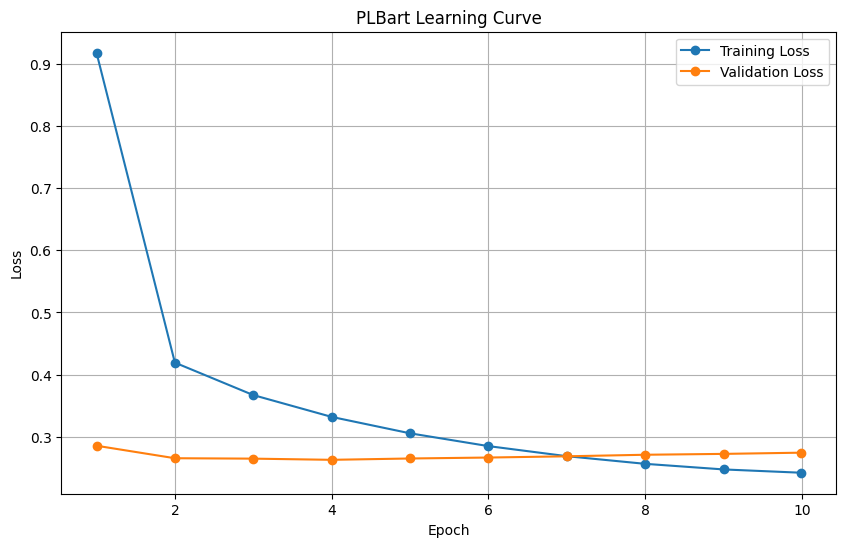

In [ ]:
print("Training completed. Collecting metrics for learning curve...")
log_history = trainer.state.log_history

# Separate training and validation losses with corresponding epochs
train_losses = []
train_epochs = []
val_losses = []
val_epochs = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:  # Training loss
        train_losses.append(log['loss'])
        train_epochs.append(log['epoch'])
    if 'eval_loss' in log and 'epoch' in log:  # Validation loss
        val_losses.append(log['eval_loss'])
        val_epochs.append(log['epoch'])

# Print metrics for debugging
print("Training epochs:", train_epochs)
print("Training losses:", train_losses)
print("Validation epochs:", val_epochs)
print("Validation losses:", val_losses)

# Plot the learning curve
plt.figure(figsize=(10, 6))
if train_epochs and train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss', marker='o')
if val_epochs and val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PLBart Learning Curve')
plt.legend()
plt.grid(True)
plt.savefig('results/plbart_learning_curve.png')
plt.show()

#### Model Saving

In [ ]:
# saving trained model
trainer.save_model('models/plbart/plbart_python_correction')
plbart_tokenizer.save_pretrained('models/plbart/plbart_python_correction')

('models/plbart/plbart_python_correction/tokenizer_config.json',
 'models/plbart/plbart_python_correction/special_tokens_map.json',
 'models/plbart/plbart_python_correction/sentencepiece.bpe.model',
 'models/plbart/plbart_python_correction/added_tokens.json')

In [ ]:
# zipping the finetuned model
model_dir = 'models/plbart/plbart_python_correction'
zip_path = 'models/plbart/plbart_python_correction.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_dir)
FileLink(zip_path)

/kaggle/working/models/plbart/plbart_python_correction.zip

In [ ]:
# checking the model size
size_bytes = get_dir_size('models/plbart/plbart_python_correction')
size_mb = size_bytes / (1024 * 1024)

print(f"Directory size: {size_mb:.2f} MB")

Directory size: 532.25 MB


In [ ]:
# Save training metrics
metrics = trainer.state.log_history
metrics_df = pd.DataFrame([
    {
        'epoch': m.get('epoch', None),
        'train_loss': m.get('loss', None),
        'val_loss': m.get('eval_loss', None)
    } for m in metrics if 'loss' in m or 'eval_loss' in m
])

csv_path = os.path.join('models/plbart', 'plbart_training_scores.csv')
metrics_df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
    try:
        if 'IPython' in sys.modules and hasattr(sys.modules['IPython'], 'get_ipython'):
            csv_link = FileLink(csv_path)
            display(csv_link)
            print(f"Download training metrics CSV: {csv_link}")
    except Exception as e:
        print(f"Failed to create FileLink. Access the metrics CSV at: {os.path.abspath(csv_path)}")

/kaggle/working/models/plbart/plbart_training_scores.csv

Download training metrics CSV: /kaggle/working/models/plbart/plbart_training_scores.csv


# Generate Translation

In [ ]:
plbart_model

PLBartForConditionalGeneration(
  (model): PLBartModel(
    (shared): PLBartScaledWordEmbedding(50005, 768, padding_idx=1)
    (encoder): PLBartEncoder(
      (embed_tokens): PLBartScaledWordEmbedding(50005, 768, padding_idx=1)
      (embed_positions): PLBartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x PLBartEncoderLayer(
          (self_attn): PLBartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

#### Dataset Translation

In [ ]:
os.makedirs('outputs/plbart_translations')
print("Test Data for Evaluate the Model: ")           # translated with beam size of 10 and batch size of 8
test_translated_eval = generate_translations(plbart_model, plbart_tokenizer, test_loader, output_file='outputs/plbart_translations/test.translated-python-eval.python')

Test Data for Evaluate the Model: 


Generating Translations: 100%|██████████| 110/110 [20:02<00:00, 10.93s/it]


✅ Translations saved to: outputs/plbart_translations/test.translated-python-eval.python


*****
# Evaluation

In [ ]:
evaluate_model((cwd+'/datasets/test.java-python.python'), (cwd+'/outputs/plbart_translations/test.translated-python-eval.python'), stage="PLBART")

{'em_score': 0.006300114547537228, 'bleu': 0.536708325927905}

*****
# Inference

In [33]:
class JavaToPythonPipeline:
    def __init__(self,codet5_path='models/codet5/checkpoint_epoch_10', plbart_path='models/plbart/plbart_python_correction', device=None):
        print("Initializing pipeline...")
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # load codet5 andtokenizers model from checkppoint
        print("Initializing CodeT5 model and tokenizer")
        self.codet5_tokenizer = RobertaTokenizer.from_pretrained(codet5_path)
        self.codet5_model = T5ForConditionalGeneration.from_pretrained(codet5_path).to(self.device)

        # load plbart model and tokenizers model from checkppoint
        print("Initializing PLBART model and tokenizer")
        self.plbart_tokenizer = PLBartTokenizer.from_pretrained(plbart_path)
        self.plbart_model = PLBartForConditionalGeneration.from_pretrained(plbart_path).to(self.device)

    def translate_java_to_python(self, java_code):
        """ step 1 translation using the codet5 model """
        input_text = f"translate Java to Python: {java_code}"
        inputs = self.codet5_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(self.device)
        output_ids = self.codet5_model.generate(inputs["input_ids"], max_length=256)
        translated_code = self.codet5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return translated_code

    def correct_python_code(self, python_code):
        """ step 2 correction or minimize of the translated python code """
        inputs = self.plbart_tokenizer(python_code, return_tensors="pt", padding=True, truncation=True).to(self.device)
        output_ids = self.plbart_model.generate(inputs["input_ids"], max_length=256)
        corrected_code = self.plbart_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return corrected_code

    def restore_python_code(self, encoded_code):
        lines = encoded_code.split("NEW_LINE")
        indent_level = 0
        indent_str = "    "
        restored_lines = []

        for raw_line in lines:
            line = raw_line.strip()
            while line.startswith("DEDENT"):
                indent_level = max(indent_level - 1, 0)
                line = line[len("DEDENT"):].strip()
            while line.startswith("INDENT"):
                indent_level += 1
                line = line[len("INDENT"):].strip()

            if line:
                normalized_main_line = "if __name__ == '__main__':"
                cleaned_line = line.replace(" ", "").replace('"', "'")
                if cleaned_line == "if__name__=='__main__':":
                    restored_lines.append(normalized_main_line)
                else:
                    restored_lines.append(indent_str * indent_level + line)

        return "\n".join(restored_lines)

    def __call__(self, java_code, debug=False):
        translated = self.translate_java_to_python(java_code)
        minimized = self.correct_python_code(translated)


        translated_restored = self.restore_python_code(translated)
        minimized_restored = self.restore_python_code(minimized)

        return translated_restored, minimized_restored

In [34]:
pipeline = JavaToPythonPipeline()

java_code_sample_0 = """
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}
"""

java_code_sample_1 = """
public class Main {
  public static void main(String[] args) {
    int result = sum(5, 10);
    System.out.println(result);
  }
  public static int sum(int start, int end) {
    if (end > start) {
      return end + sum(start, end - 1);
    } else {
      return end;
    }
  }
}
"""

java_code_sample_2="""
import java.util.HashSet;

public class Main {
  public static void main(String[] args) {
    HashSet<String> cars = new HashSet<String>();
    cars.add("Volvo");
    cars.add("BMW");
    cars.add("Ford");
    cars.add("BMW");
    cars.add("Mazda");
    System.out.println(cars);
  }
}
"""

java_code_sample_3 = """
public class WhileLoopExample {
    public static void main(String[] args) {
        int count = 1;

        while (count <= 5) {
            System.out.println("Count is: " + count);
            count++;
        }
    }
}
"""

java_code_sample_4 = """
public class CountFives {
    public static void main(String[] args) {
        int[] numbers = {5, 1, 5, 3, 5, 7, 2, 5};
        int count = 0;

        for (int num : numbers) {
            if (num == 5) {
                count++;
            }
        }

        System.out.println("Number of times 5 appears: " + count);
    }
}
"""

Initializing pipeline...
Initializing CodeT5 model and tokenizer
Initializing PLBART model and tokenizer


In [35]:
v1, v2 = pipeline(java_code_sample_0)
print("Example: 1 =========================================================================================")
print("Java Code: \n",java_code_sample_0)
print("\nInitial Translated Python Code:\n", v1)
print("\nMinimized/Corrected Python Code:\n", v2)

v1, v2 = pipeline(java_code_sample_1)
print("\nExample: 2 =========================================================================================")
print("Java Code: \n",java_code_sample_1)
print("\nInitial Translated Python Code:\n", v1)
print("\nMinimized/Corrected Python Code:\n", v2)

v1, v2 = pipeline(java_code_sample_2)
print("\nExample: 3 =========================================================================================")
print("Java Code: \n",java_code_sample_2)
print("\nInitial Translated Python Code:\n", v1)
print("\nMinimized/Corrected Python Code:\n", v2)

v1, v2 = pipeline(java_code_sample_3)
print("\nExample: 4 =========================================================================================")
print("Java Code: \n",java_code_sample_3)
print("\nInitial Translated Python Code:\n", v1)
print("\nMinimized/Corrected Python Code:\n", v2)

v1, v2 = pipeline(java_code_sample_4)
print("\nExample: 5 =========================================================================================")
print("Java Code: \n",java_code_sample_4)
print("\nInitial Translated Python Code:\n", v1)
print("\nMinimized/Corrected Python Code:\n", v2)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Example: 1 =========================================================================================
Java Code: 
 
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}


Initial Translated Python Code:
 def main ( ) :
    print ( "Hello , World!" )
if __name__ == '__main__':
    main ( )

Minimized/Corrected Python Code:
 print ( "Hello, World " )

Example: 2 =========================================================================================
Java Code: 
 
public class Main {
  public static void main(String[] args) {
    int result = sum(5, 10);
    System.out.println(result);
  }
  public static int sum(int start, int end) {
    if (end > start) {
      return end + sum(start, end - 1);
    } else {
      return end;
    }
  }
}


Initial Translated Python Code:
 def sum ( start , end ) :
    if end > start :
        return end + sum ( start , end - 1 )
    else :
        return end
result = sum ( 5 , 10 )
pr